*Author*: Vedran

*Original date*: 12 Feb 2020

*Last update*: 12 Feb 2020

# Sampling from random array

### Problem definition
A decision tree algorithm has to split each node following this prescription:
1. Go through each feature, for each feature split the dataset for each value of the feature
2. For each of the above, compute Gini impurity of the parent and the children nodes
3. Find the maximum Gini impurity decrease, namely the feature and the threshold for which the Gini impurity decrease is maximized

The above algorithm takes a lot of time to complete for continuous variables (for example, in a database with millions of customers, each having hundreds of transactions, there would be possibly hundreds of millions of different values for the transaction amount). Evaluating the above for every single possibility is unnecessary and expensive. 

### Solution explanation
I solve the problem here by writing a code that takes a predetermined number of sample thresholds, respecting the distribution of the data (sampling more heavily around the peaks), and it does so rather quickly.
The code sorts the dataset once and then retrieves values at prespecified number of different quantiles.

### Solution example
Suppose the array is (-1, 0, 5, -5, 1). The algorithm sorts the array to (-5, -1, 0, 1, 5). If it was asked to retrieve 3 points, it would take n-quantiles for n=0, 0.5, 1. In other words it would return min, max and median, or -5, 0, and 5.

### Addendum
I was not sure whether to sort with numpy or pandas, so there's an addendum comparing numpy and pandas sorting. The results of the test were inconclusive, so I went with the option that was easier to code and read.

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [20]:
#generate random sample
sample = pd.DataFrame(np.random.randn(100), columns={"rand_num"})

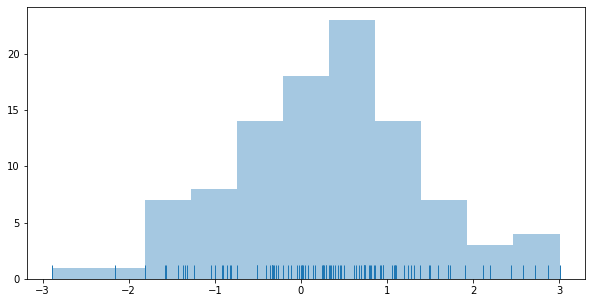

In [26]:
#visualize distro
plt.figure(figsize=(10,5))
sns.distplot(sample, kde=False, rug=True)

In [34]:
#a threshold will split the data set in points above and below threshold.
#for example, if threshold is -1, more than 3/4 of the sample would go in the "right" branch of the tree
#since i'd like to avoid having splits in which the two branches have very different number of samples, 
#i'd prefer to sample more around the "peaks" of the distribution.
sum(sample['rand_num']>-1)

88

In [47]:
sample.quantile(.532)[0]

0.38942226298615035

### Two simple (and similar) algorithms to get quantiles

The following is the very simplest routine one can write to solve the problem as described in the header. It uses pandas quantiles function, which makes the solution slower by repeatedly having to sort the array.

In [153]:
def get_quantiles(array, share_of_values):
    '''
    Returns quantiles of an array. Parameter share_of_values specifies how many quantiles should be returned.
    The output is a list of linearly spaced quantiles between min and max of the distribution.
    '''
    if share_of_values>0 and share_of_values<=1:
        number_of_quantiles = int(len(array)*share_of_values) #number of quantiles that we want to extract
        quantiles = np.linspace(0,1, number_of_quantiles) # which quantiles we want to extract
        values = []
        for i in quantiles:
            values.append(array.quantile(i)[0]) #add i-th quantile to the list of quantile values
        #return values
    else:
        print("share of values should lie between 0 and 1")

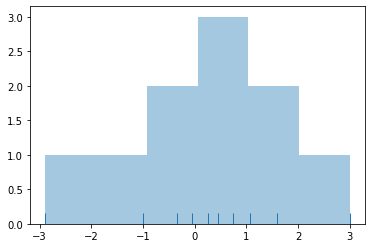

In [66]:
#by employing the above method we sample more often in vicinity of the distribution "peak"
sns.distplot(get_quantiles(sample,.1), kde=False, rug=True)

The following algorithm is an improvement in that it sorts the array only once, and computes quantiles quickly from there.

In [152]:
def get_quantiles_quickly(array, share_of_values):
    '''
    Returns quantiles of an array. Parameter share_of_values specifies how many quantiles should be returned.
    The output is a list of linearly spaced quantiles between min and max of the distribution.
    '''
    if share_of_values>0 and share_of_values<=1:
        array_length = len(array)
        array_sorted = array.sort_values(by=array.columns[0]) # sort array once
        number_of_quantiles = int(len(array)*share_of_values) #number of quantiles that we want to extract
        quantiles = np.linspace(0,1, number_of_quantiles) # which quantiles we want to extract
        values = []
        for i in quantiles[:-1]:
            values.append(array_sorted.iloc[int(i*array_length)][0]) #add i-th quantile to the list of quantile values
        values.append(array_sorted.iloc[-1][0]) #the last element isn't handled properly by the linspace trick above
        #return values
    else:
        print("share of values should lie between 0 and 1")

### Comparison of the algorithms

In [166]:
def compare_algos(samples, sample_size):
    t1=0 #timer for get_quantiles
    t2=0 #timer for get_quantiles_quickly
    for i in range(samples):
        sample = pd.DataFrame( np.random.randn(sample_size) )
        t=time.perf_counter()
        get_quantiles(sample, .5)
        t1+=time.perf_counter()-t
        t=time.perf_counter()
        get_quantiles_quickly(sample, .5)
        t2+=time.perf_counter()-t
    print(f"get_quantiles finished in {t1:.2f}sec and get_quantiles_quickly in {t2:.2f}sec. \n The test was run on {samples} sample arrays with {sample_size} elements each.")        

In [169]:
compare_algos(100,1000)

get_quantiles finished in 36.16sec and get_quantiles_quickly in 6.13sec. 
 The test was run on 100 sample arrays with 1000 elements each.


### Testing pandas vs numpy for sorting

In [116]:
# measuring using process time. use perf_counter for physical time
def sort_pandas_vs_numpy(num_arrays, num_elements):
    large_sample = np.random.randn(num_arrays,num_elements)
    large_sample_df = pd.DataFrame(large_sample)
    # time numpy
    t = time.process_time()
    for i in range(0,num_arrays):
        np.sort(large_sample[i,:])
    print(f"numpy took {time.process_time()-t:.2f} seconds to sort {num_arrays} arrays with {num_elements} elements each.")
    # time pandas
    t = time.process_time()
    for i in range(0,num_arrays):
        large_sample_df[i].sort_values()
    print(f"pandas took {time.process_time()-t:.2f} seconds to sort {num_arrays} arrays with {num_elements} elements each.") 

In [131]:
# running this multiple times with a couple of different choices for the number of arrays and the number of elements
# i've concluded that most of the time numpy is faster, but sometimes pandas is faster. in general they're quite similar
# none seemed to become better by increasing the parameters
sort_pandas_vs_numpy(5000,20000)

numpy took 7.21 seconds to sort 5000 arrays with 20000 elements each.
pandas took 9.74 seconds to sort 5000 arrays with 20000 elements each.
